In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from einops import rearrange
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split

from uni2ts.eval_util.plot import plot_single, plot_next_multi
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

MODEL = "moirai-moe"  # model name: choose from {'moirai', 'moirai-moe'}

# 1. Forecasting with Moirai

<img src="img/pred_def.png" alt="Drawing" style="width: 800px;"/>

Given a time series, Moirai (prediction model) use the context window as input and outputs a prediction window. So, the user need to set the **context_length** and **prediction_length** in advance. 

For time series data, the information contained within a single timestamp is not rich enough. Therefore, we refer to consecutive time points as 'patches', forming the basic units of Moirai input (similar to the concept of word token in Language Models). Moirai provides various ***patch_size*** [8, 16, 32, 64, 128].

Additionally, users need to select the **model size** ('small', 'base', 'large') of Moirai for prediction, along with the **batch_size**, which determines the number of samples that can be inferred in parallel. Since Moirai supports probablistic forecast, users should specify the **num_samples**, indicating the number of times it has to sample the forecasting distribution.

total length: 240
time frequency: 0 days 01:00:00


<Axes: >

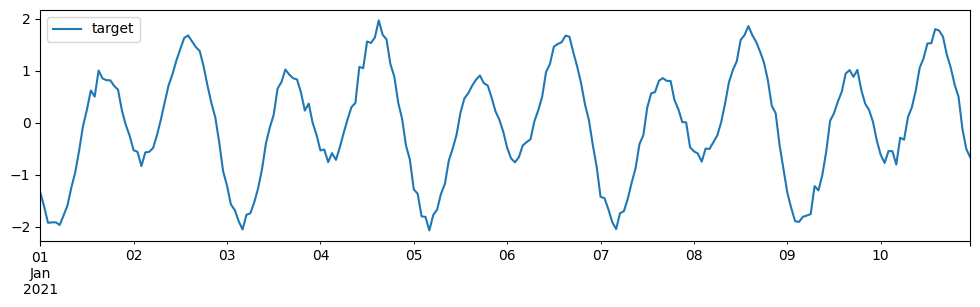

In [2]:
# Load dataframe and plot it
url = (
    "https://gist.githubusercontent.com/rsnirwan/a8b424085c9f44ef2598da74ce43e7a3"
    "/raw/b6fdef21fe1f654787fa0493846c546b7f9c4df2/ts_long.csv"
)
df = pd.read_csv(url, index_col=0, parse_dates=True)
df = df[df["item_id"] == "A"].drop(columns=["item_id"])
print(f"total length: {df.shape[0]}")
print(f"time frequency: {df.index.diff()[1]}")
df.plot(figsize=(12, 3))

In [24]:
df

,target,item_id,dynamic_real_1,past_dynamic_real_2
2021-01-01 00:00:00,-1.3378,A,0.143050,1.824585
2021-01-01 01:00:00,-1.6111,A,0.536893,-0.061460
2021-01-01 02:00:00,-1.9259,A,0.170522,0.384135
2021-01-01 03:00:00,-1.9184,A,-0.497669,1.254558
2021-01-01 04:00:00,-1.9168,A,0.770285,1.119456
...,...,...,...,...
2021-01-10 19:00:00,1.2349,J,-0.977048,0.049596
2021-01-10 20:00:00,1.1525,J,-0.082336,-2.216978
2021-01-10 21:00:00,1.1485,J,0.849105,0.308417
2021-01-10 22:00:00,1.3248,J,0.704528,0.768502


In [3]:
# create a sample for the hourly data, using one week data as context window and predicting the next two days.
inp = {
    "target": df["target"].to_numpy()[:168],  # 168 = 24 * 7
    "start": df.index[0].to_period(freq="H"),
}
label = {
    "target": df["target"].to_numpy()[168:216],  # 48 = 24 * 2
    "start": df.index[168].to_period(freq="H"),
}

In [4]:
# Prepare model
if MODEL == "moirai":
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small"),
        prediction_length=48,
        context_length=168,
        patch_size=32,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=0,
        past_feat_dynamic_real_dim=0,
    )
elif MODEL == "moirai-moe":
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-small"),
        prediction_length=48,
        context_length=168,
        patch_size=16,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=0,
        past_feat_dynamic_real_dim=0,
    )

# Time series values. Shape: (batch, time, variate)
past_target = rearrange(
    torch.as_tensor(inp["target"], dtype=torch.float32), "t -> 1 t 1"
)
# 1s if the value is observed, 0s otherwise. Shape: (batch, time, variate)
past_observed_target = torch.ones_like(past_target, dtype=torch.bool)
# 1s if the value is padding, 0s otherwise. Shape: (batch, time)
past_is_pad = torch.zeros_like(past_target, dtype=torch.bool).squeeze(-1)

forecast = model(
    past_target=past_target,
    past_observed_target=past_observed_target,
    past_is_pad=past_is_pad,
)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/469M [00:00<?, ?B/s]

In [5]:
print(
    "median prediction:\n",
    np.round(np.median(forecast[0], axis=0), decimals=4),
)
print("ground truth:\n", label["target"])

median prediction:
 [-0.8862 -1.0617 -1.2558 -1.2912 -1.3336 -1.3327 -1.1168 -1.1368 -0.9623
 -0.5492 -0.2549 -0.3169 -0.0388  0.315   0.2401  0.435   0.518   0.4719
  0.2903  0.1705 -0.2844 -0.4695 -0.7376 -1.0741 -1.5196 -1.6745 -1.683
 -1.8107 -1.8513 -1.683  -1.6    -1.2571 -1.1858 -0.8899 -0.6716 -0.3571
 -0.0136  0.2365  0.2704  0.0362  0.2556  0.271   0.2374 -0.053  -0.0945
 -0.3346 -0.6492 -0.838 ]
ground truth:
 [-0.5511 -0.5932 -0.7505 -0.4978 -0.5051 -0.3753 -0.244   0.0095  0.3692
  0.7807  1.0135  1.1805  1.5927  1.6855  1.8593  1.685   1.5527  1.3677
  1.1558  0.8158  0.3267  0.1822 -0.427  -0.8917 -1.3495 -1.6403 -1.8952
 -1.9084 -1.8111 -1.7865 -1.7594 -1.2197 -1.3027 -1.0029 -0.5541  0.037
  0.1842  0.4091  0.5988  0.9457  1.0123  0.8828  1.0167  0.6306  0.3671
  0.2454  0.0181 -0.3464]


# 2. Rolling Evaluation

<img src="img/rolling_eval.png" alt="Drawing" style="width: 800px;"/>

As shown in the above plot, we use GluonTS to construct rolling window evaluation

## Settings
SIZE: model size, select the model size of Moirai to perform inference with

PDT: prediction length, how many time steps to predict into the future

CTX: context length, how many time steps the model will take as input for inference

PSZ: patch size, how many time steps to perform patching with

BSZ: batch size, number of samples in each batch for inference

TEST: test set length, number of time steps to hold out for test set

In [6]:
SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
PDT = 20  # prediction length: any positive integer
CTX = 200  # context length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer
TEST = 100  # test set length: any positive integer

## 2.1 Loading from a _long_ DataFrame

In [25]:
# Load dataframe
url = (
    "https://gist.githubusercontent.com/rsnirwan/a8b424085c9f44ef2598da74ce43e7a3"
    "/raw/b6fdef21fe1f654787fa0493846c546b7f9c4df2/ts_long.csv"
)
df = pd.read_csv(url, index_col=0, parse_dates=True)

df.head()

,target,item_id
2021-01-01 00:00:00,-1.3378,A
2021-01-01 01:00:00,-1.6111,A
2021-01-01 02:00:00,-1.9259,A
2021-01-01 03:00:00,-1.9184,A
2021-01-01 04:00:00,-1.9168,A


In [8]:
# Convert into GluonTS dataset
ds = PandasDataset.from_long_dataframe(df, target="target", item_id="item_id")

# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

In [9]:
# Prepare model
if MODEL == "moirai":
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=PSZ,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )
elif MODEL == "moirai-moe":
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-small"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=16,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

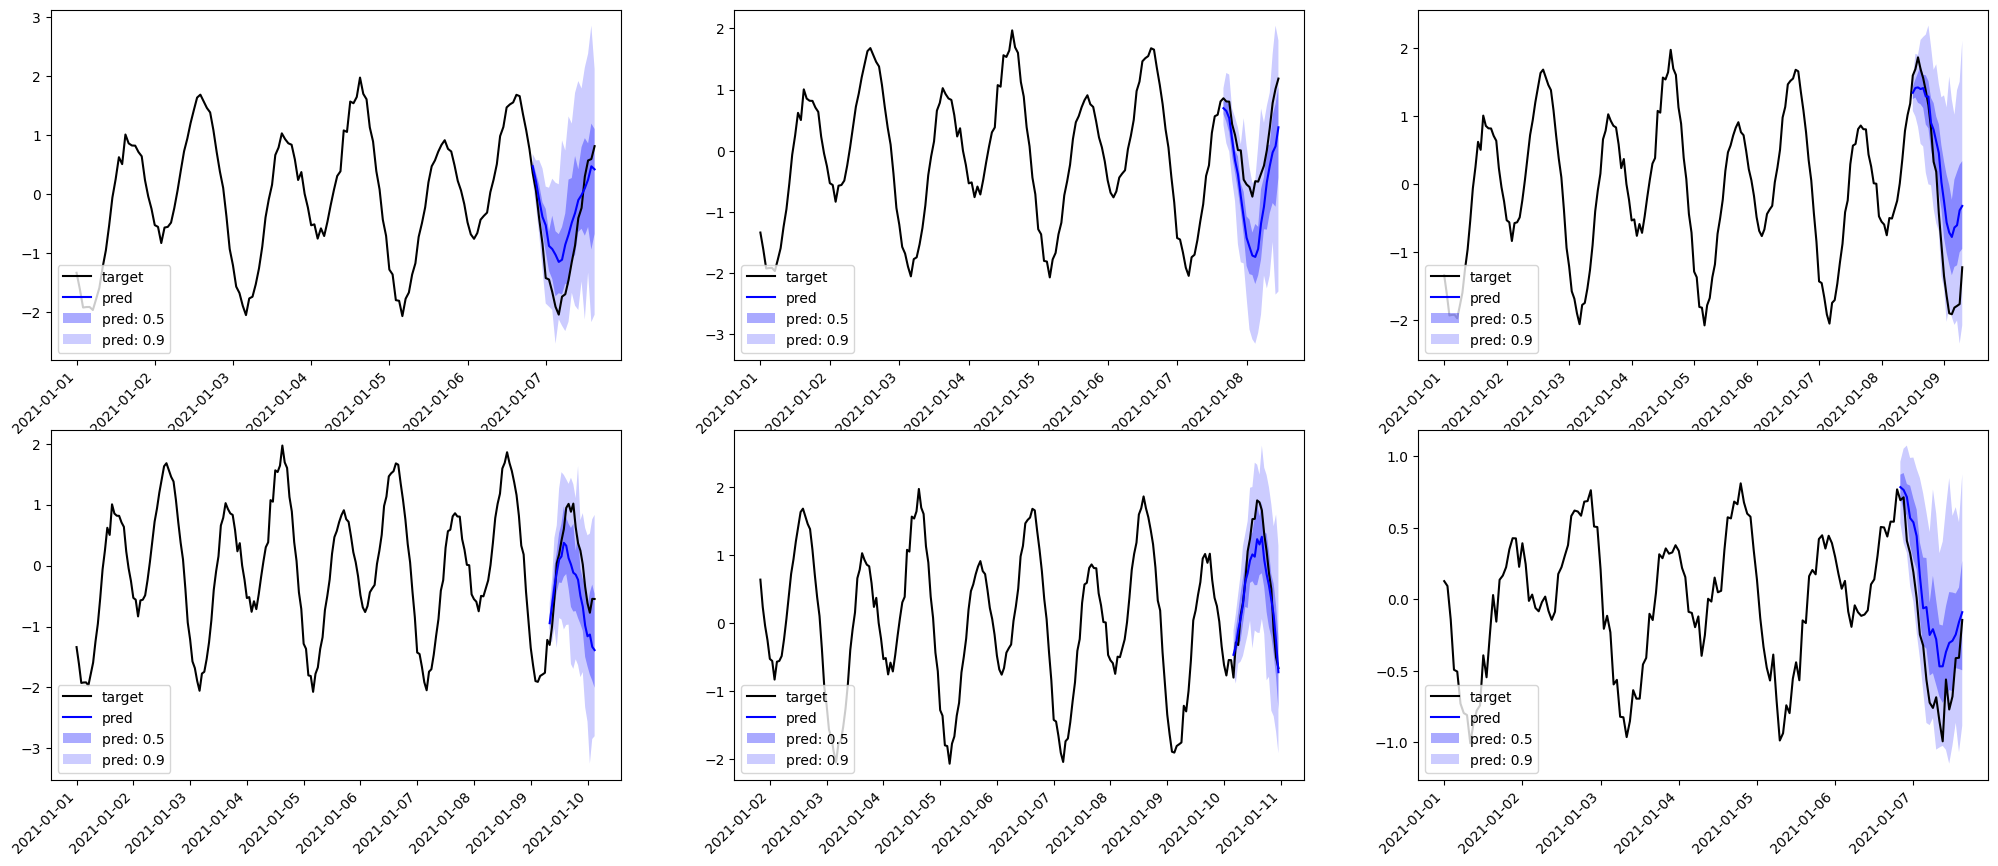

In [10]:
# Make predictions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)

## 2.2 Loading from a _wide_ DataFrame

In [11]:
# Load dataframe
url_wide = (
    "https://gist.githubusercontent.com/rsnirwan/c8c8654a98350fadd229b00167174ec4"
    "/raw/a42101c7786d4bc7695228a0f2c8cea41340e18f/ts_wide.csv"
)
df = pd.read_csv(url_wide, index_col=0, parse_dates=True)

df.head()

,A,B,C,D,E,F,G,H,I,J
2021-01-01 00:00:00,-1.3378,0.1268,-0.3645,-1.0864,-2.3803,-0.2447,2.2647,-0.7917,0.7071,1.3763
2021-01-01 01:00:00,-1.6111,0.0926,-0.1364,-1.1613,-2.1421,-0.3477,2.4262,-0.9609,0.6413,1.2750
2021-01-01 02:00:00,-1.9259,-0.1420,0.1063,-1.0405,-2.1426,-0.3271,2.4434,-0.9034,0.4323,0.6767
2021-01-01 03:00:00,-1.9184,-0.4930,0.6269,-0.8531,-1.7060,-0.3088,2.4307,-0.9602,0.3193,0.5150
2021-01-01 04:00:00,-1.9168,-0.5057,0.9419,-0.7666,-1.4287,-0.4284,2.3258,-1.2504,0.3660,0.1708


In [12]:
# Convert into GluonTS dataset
ds = PandasDataset(dict(df))

# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

In [13]:
# Prepare model
if MODEL == "moirai":
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=PSZ,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )
elif MODEL == "moirai-moe":
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-small"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=16,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

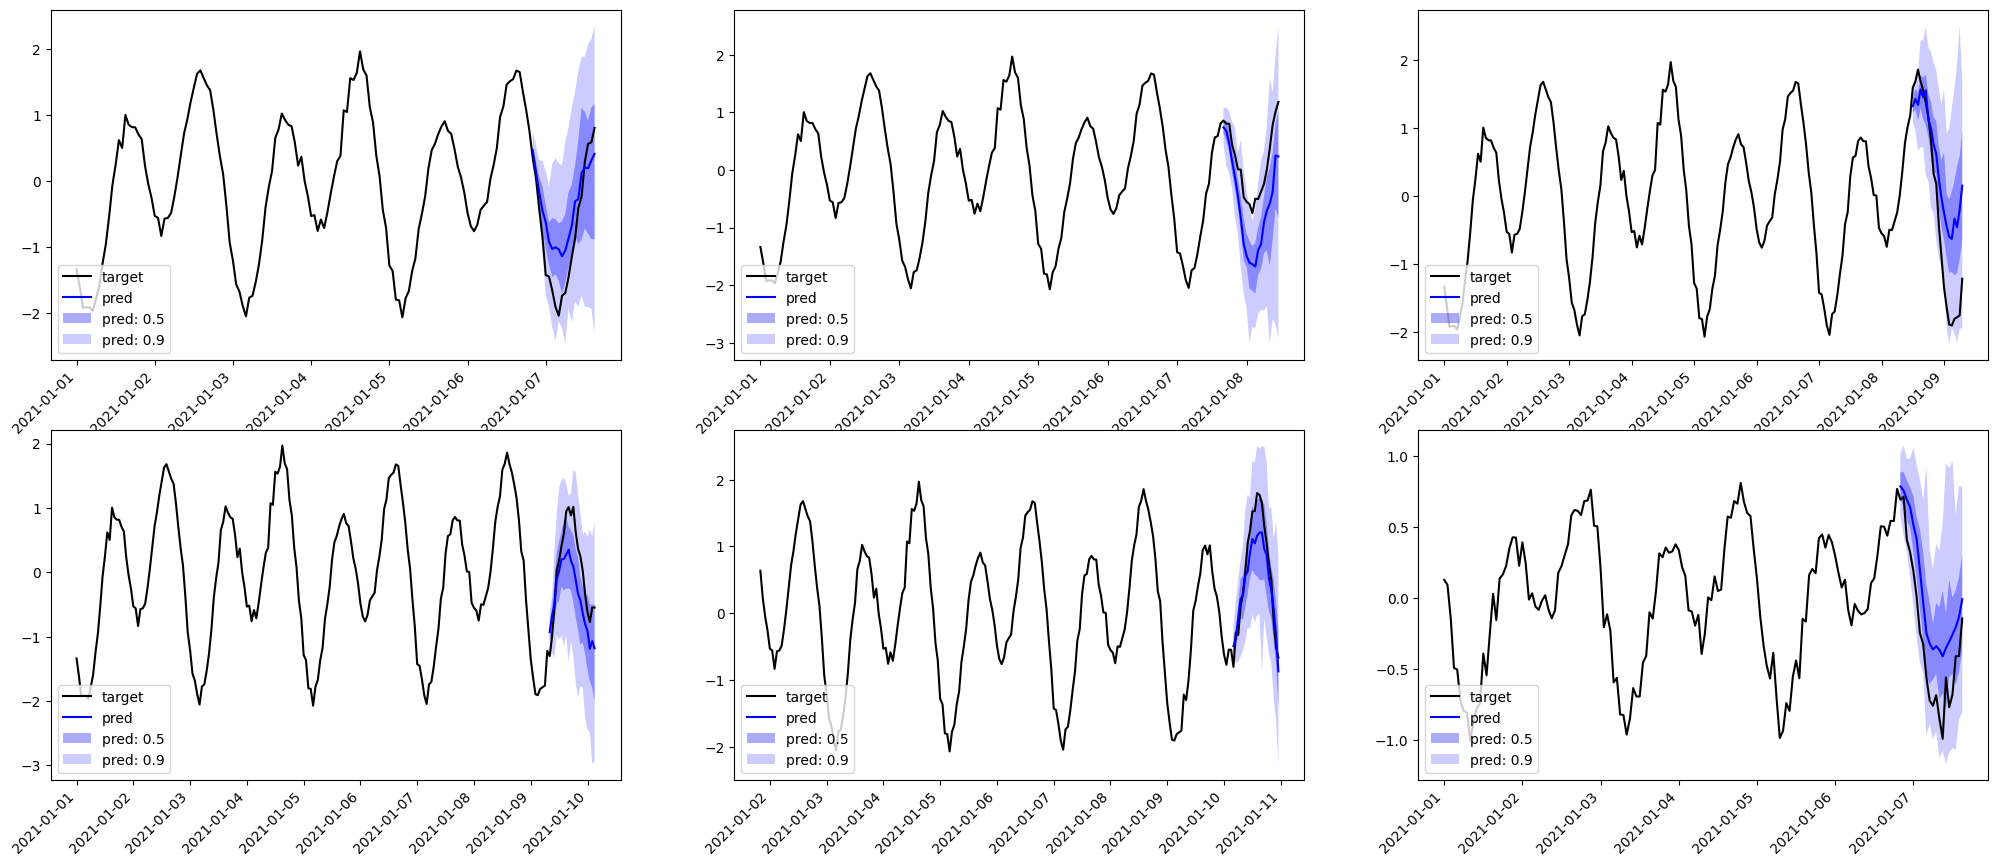

In [14]:
# Make predictions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)

# 2.3 Multivariate Forecasting

In [26]:
# Load dataframe
url_wide = (
    "https://gist.githubusercontent.com/rsnirwan/c8c8654a98350fadd229b00167174ec4"
    "/raw/a42101c7786d4bc7695228a0f2c8cea41340e18f/ts_wide.csv"
)
df = pd.read_csv(url_wide, index_col=0, parse_dates=True)
df

,A,B,C,D,E,F,G,H,I,J
2021-01-01 00:00:00,-1.3378,0.1268,-0.3645,-1.0864,-2.3803,-0.2447,2.2647,-0.7917,0.7071,1.3763
2021-01-01 01:00:00,-1.6111,0.0926,-0.1364,-1.1613,-2.1421,-0.3477,2.4262,-0.9609,0.6413,1.2750
2021-01-01 02:00:00,-1.9259,-0.1420,0.1063,-1.0405,-2.1426,-0.3271,2.4434,-0.9034,0.4323,0.6767
2021-01-01 03:00:00,-1.9184,-0.4930,0.6269,-0.8531,-1.7060,-0.3088,2.4307,-0.9602,0.3193,0.5150
2021-01-01 04:00:00,-1.9168,-0.5057,0.9419,-0.7666,-1.4287,-0.4284,2.3258,-1.2504,0.3660,0.1708
...,...,...,...,...,...,...,...,...,...,...
2021-01-10 19:00:00,0.7328,0.6937,-0.3679,-0.6389,-1.3643,0.1667,0.3918,-0.4162,0.9811,1.2349
2021-01-10 20:00:00,0.4957,0.7043,-0.5553,-0.8691,-1.8283,0.0413,0.8977,-0.5412,1.0969,1.1525
2021-01-10 21:00:00,-0.1209,0.5297,-0.7084,-1.0384,-2.0439,0.0534,1.3973,-0.6366,1.1286,1.1485
2021-01-10 22:00:00,-0.5072,0.5816,-0.5735,-1.3990,-2.1105,-0.0674,1.3225,-0.5672,1.0786,1.3248


In [16]:
# Convert into GluonTS dataset
ds = PandasDataset(dict(df))

# Group time series into multivariate dataset
grouper = MultivariateGrouper(len(ds))
multivar_ds = grouper(ds)

# Split into train/test set
train, test_template = split(
    multivar_ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

In [17]:
# Prepare model
if MODEL == "moirai":
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=PSZ,
        num_samples=100,
        target_dim=len(ds),
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )
elif MODEL == "moirai-moe":
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-small"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=16,
        num_samples=100,
        target_dim=len(ds),
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

In [18]:
# Make predictions
inp = next(input_it)
label = next(label_it)
forecast = next(forecast_it)

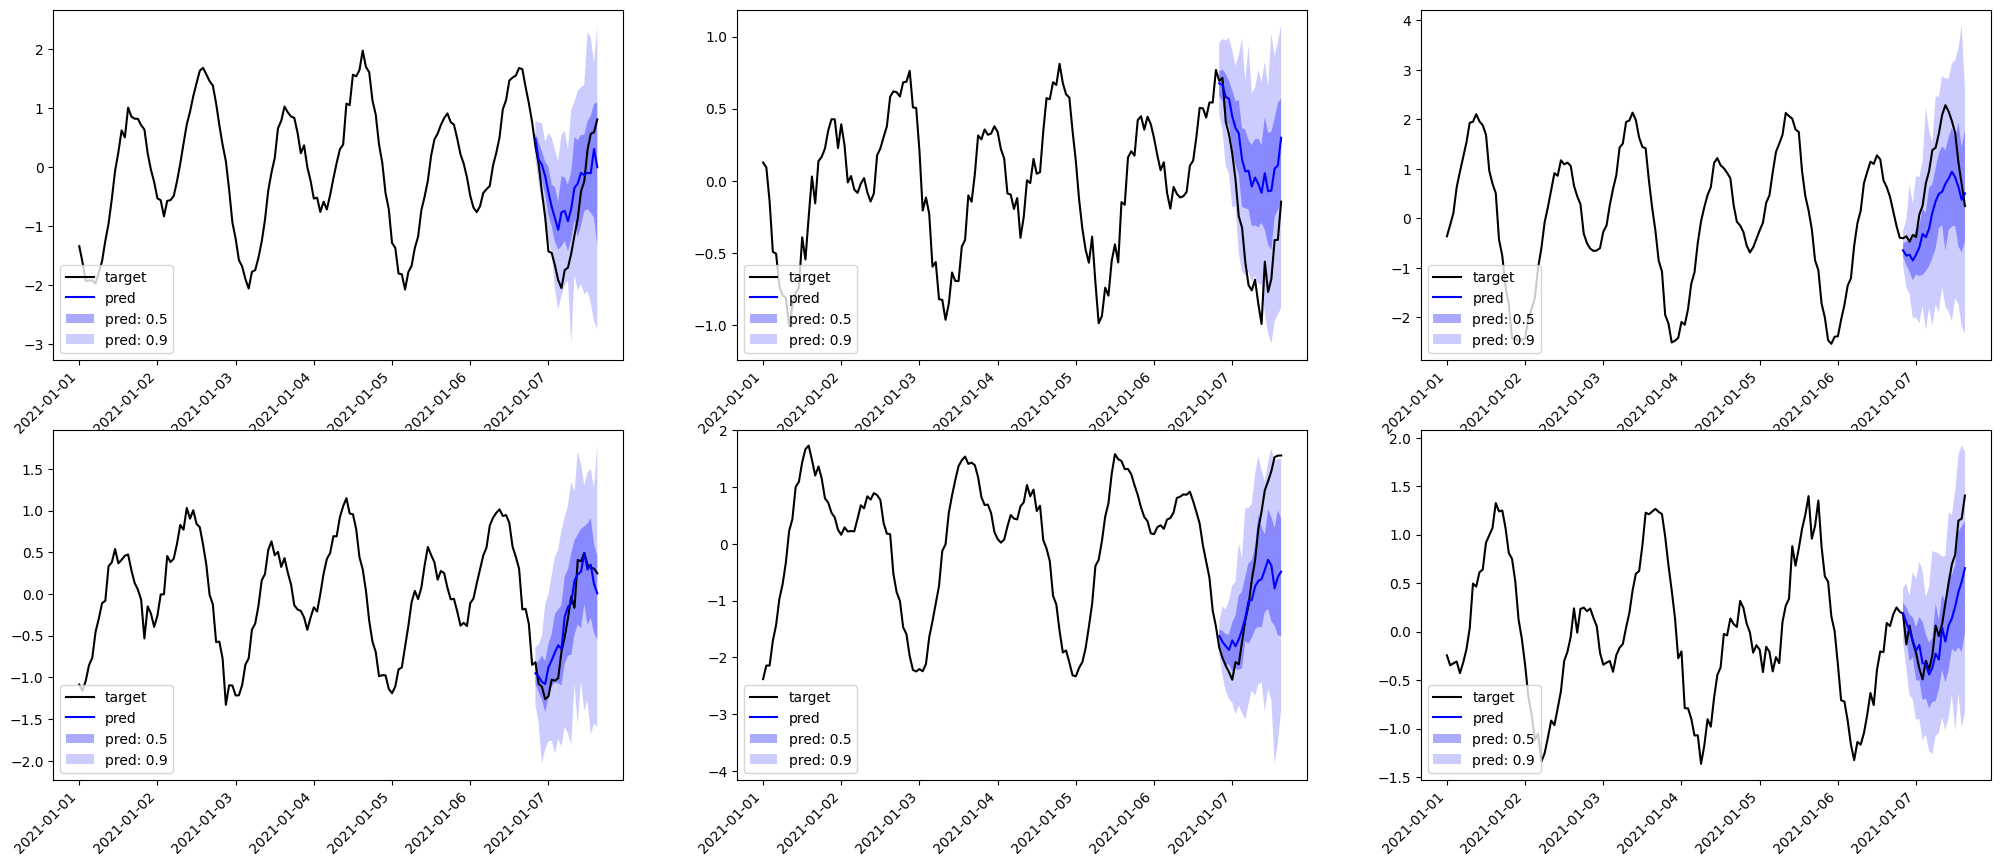

In [19]:
# Visualize different dimensions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
for i, ax in enumerate(axes.flatten()):
    plot_single(
        inp,
        label,
        forecast,
        context_length=200,
        intervals=(0.5, 0.9),
        dim=i,
        ax=ax,
        name="pred",
        show_label=True,
    )

## 2.4 Include dynamic features

<img src="img/extra_feature.png" alt="Drawing" style="width: 800px;"/>

Moirai supports adding additional covariates. Specifically, it could include past dynamic real features, and dynamic real feature that include features in the prediction window.

In [20]:
# Load dataframe
url = (
    "https://gist.githubusercontent.com/rsnirwan/a8b424085c9f44ef2598da74ce43e7a3"
    "/raw/b6fdef21fe1f654787fa0493846c546b7f9c4df2/ts_long.csv"
)
df = pd.read_csv(url, index_col=0, parse_dates=True)
T = df.shape[0]
df["dynamic_real_1"] = np.random.normal(size=T)
df["past_dynamic_real_2"] = np.random.normal(size=T)

In [21]:
ds = PandasDataset.from_long_dataframe(
    df,
    item_id="item_id",
    past_feat_dynamic_real=["past_dynamic_real_2"],
    feat_dynamic_real=["dynamic_real_1"],
)

# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

In [22]:
# Prepare model
if MODEL == "moirai":
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=PSZ,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )
elif MODEL == "moirai-moe":
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-small"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=16,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

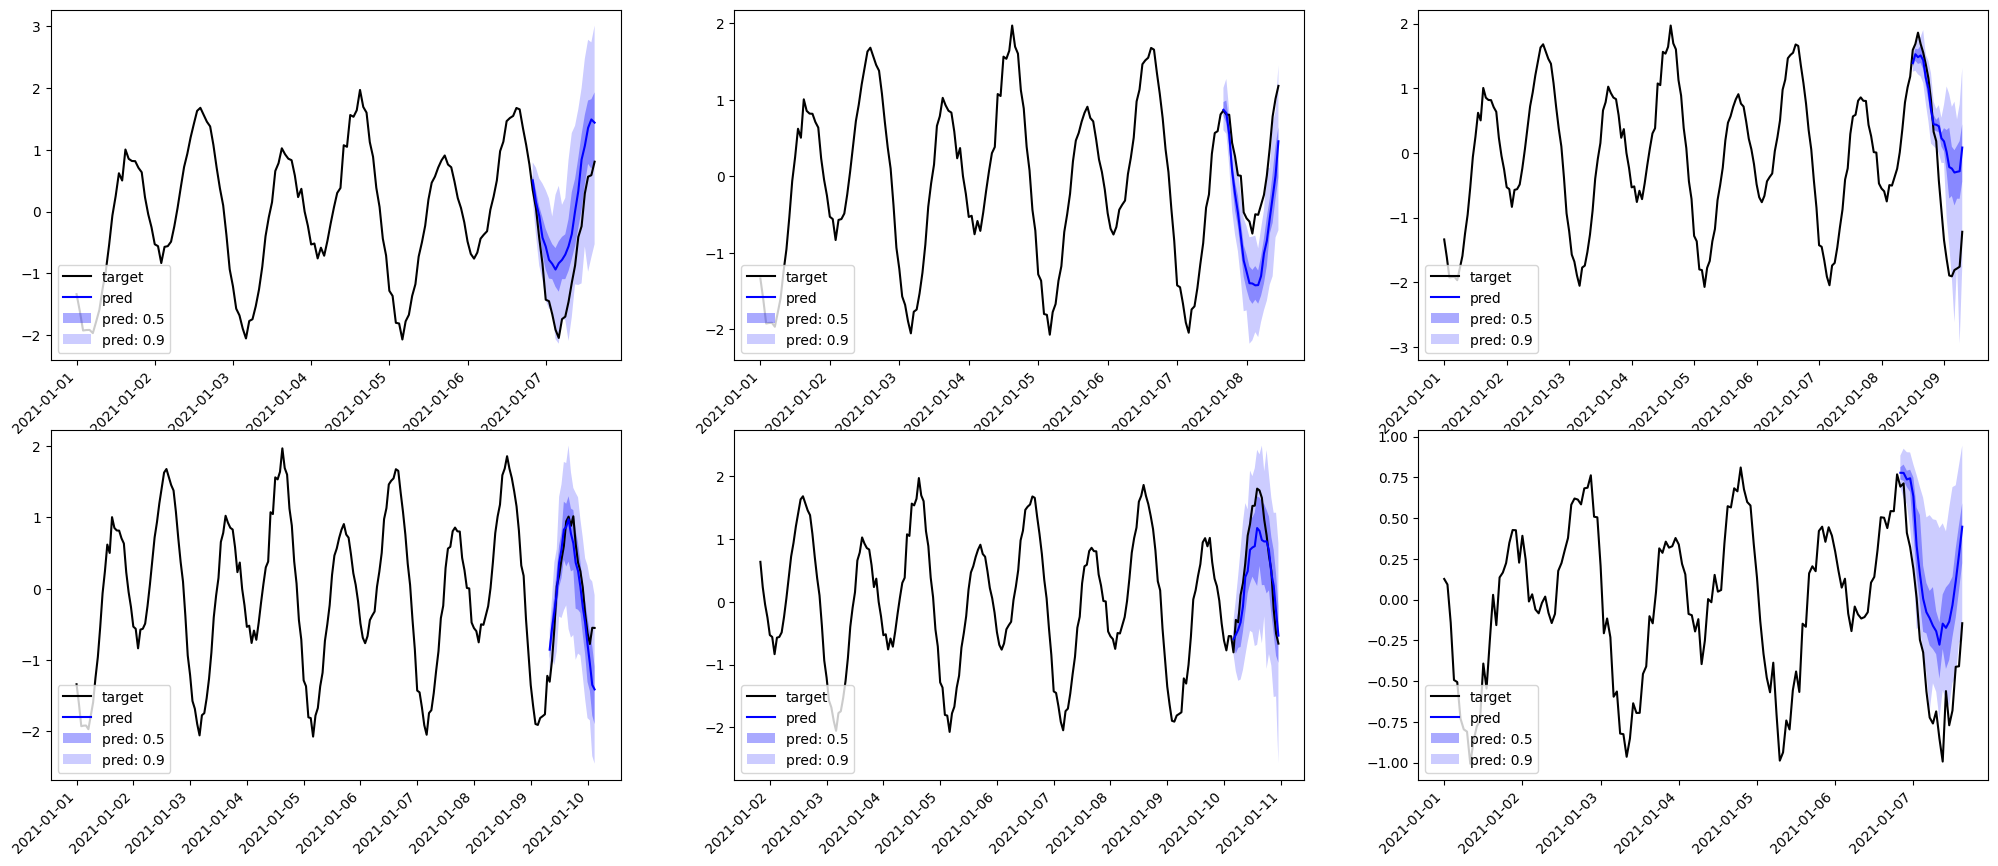

In [23]:
# Make predictions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)